In [1]:
import sys
sys.path.insert(0, "/home/hmg/econ/gettsim/")

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 144
from itertools import product

from gettsim import get_policies_for_date
from gettsim import compute_taxes_and_transfers
# from gettsim import plot_dag

# Arbeitslosengeld 2

In diesem Notebook beschäftigen wir uns mit dem Arbeitslosengeld 2. 

Analog zu den Steuern schauen wir uns zunächst an, wie sich die Transfers ändern, wenn wir das Bruttoeinkommen
ändern. Zum einen die gesamten Transfers, zum anderen die Transferentzugsrate, die analog zum Grenzsteuersatz
definiert ist. 

Dieser Teil ist vorprogrammiert. Bitte gehen Sie wie üblich langsam durch und versuchen Sie, die einzelnen
Schritte zu verstehen.

Anschließend bringen wir Transfers und Steuern zusammen und Sie berechnen selbständig die Gesamtbelastung.

## Erstellung des Steuer- und Transfersystems und der Daten

Wir setzen zunächst wieder die Parameter des Steuer- und Transfersystems auf die des Jahres 2020 fest.

In [3]:
params_dict, policy_func_dict = get_policies_for_date("2020")

In [4]:
min_einkommen = 0
max_einkommen = 2000
anzahl_schritte = 201

df_1e = pd.DataFrame(index=pd.RangeIndex(anzahl_schritte))

# Haushalts-ID und Steuersubjekt-ID: In unserem Beispiel kein Unterschied
df_1e["hh_id"] = df_1e.index
df_1e["tu_id"] = df_1e.index

# Bruttolohn, Vermögen, private Krankenversicherung sind dasselbe für alle Haushaltsmitglieder
df_1e["bruttolohn_m"] = np.linspace(min_einkommen, max_einkommen, anzahl_schritte)

# Bug in GETTSIM: bruttolohn_vorj_m muss hier mindestens 100 sein -- bitte nicht hinterfragen...
df_1e["bruttolohn_vorj_m"] = 100.0
df_1e["arbeitsl_lfdj_m"] = 0
df_1e["arbeitsl_vorj_m"] = 0
df_1e["arbeitsl_vor2j_m"] = 0
df_1e["arbeitsstunden_w"] = 5.0

# Kosten der Unterkunft sind so gewählt, das Miete erstattet wird
df_1e["kaltmiete_m_hh"] = 350
df_1e["heizkost_m_hh"] = 50
df_1e["wohnfläche_hh"] = 45
df_1e["bewohnt_eigentum_hh"] = False

# Leider noch nötig, fällt in der nächsten Version weg
df_1e["anz_erwachsene_tu"] = 1

# Der Rest setzt Einkommen auf Null etc., so dass Anspruch auf ALG 2 besteht
df_1e["vermögen_hh"] = 0.0
df_1e["tu_vorstand"] = False
df_1e["anz_minderj_hh"] = 0
df_1e["wohnort_ost"] = False
df_1e["alter"] = 50
df_1e["selbstständig"] = False
df_1e["hat_kinder"] = True
df_1e["eink_selbst_m"] = 0
df_1e["ges_rente_m"] = 0
df_1e["prv_krankenv"] = False
df_1e["geburtsjahr"] = 1970
df_1e["geburtstag"] = 1
df_1e["geburtsmonat"] = 1
df_1e["m_elterngeld_mut"] = 0
df_1e["m_elterngeld_vat"] = 0
df_1e["m_elterngeld"] = 0
df_1e["exper"] = 7
df_1e["entgeltpunkte"] = 6.2776
df_1e["kind"] = False
df_1e["rentner"] = False
df_1e["betreuungskost_m"] = 0
df_1e["prv_rente_beitr_m"] = 0
df_1e["miete_unterstellt"] = 0
df_1e["kapital_eink_m"] = 0
df_1e["vermiet_eink_m"] = 0
df_1e["jahr_renteneintr"] = 2061
df_1e["in_ausbildung"] = False
df_1e["behinderungsgrad"] = 0
df_1e["alleinerziehend"] = False
df_1e["immobilie_baujahr"] = 1970
df_1e["mietstufe"] = 1
df_1e["sonstig_eink_m"] = 0
df_1e.head(10)

,hh_id,tu_id,bruttolohn_m,bruttolohn_vorj_m,arbeitsl_lfdj_m,arbeitsl_vorj_m,arbeitsl_vor2j_m,arbeitsstunden_w,kaltmiete_m_hh,heizkost_m_hh,...,miete_unterstellt,kapital_eink_m,vermiet_eink_m,jahr_renteneintr,in_ausbildung,behinderungsgrad,alleinerziehend,immobilie_baujahr,mietstufe,sonstig_eink_m
0,0,0,0.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
1,1,1,10.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
2,2,2,20.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
3,3,3,30.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
4,4,4,40.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
5,5,5,50.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
6,6,6,60.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
7,7,7,70.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
8,8,8,80.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0
9,9,9,90.0,100.0,0,0,0,5.0,350,50,...,0,0,0,2061,False,0,False,1970,1,0


In [5]:
# Generiere Alleinerziehende mit einem Kind
df_1e_1k = df_1e.append(df_1e).copy().sort_values("hh_id").reset_index()
df_1e_1k.index.name = "p_id"

# Setze Alleinerziehenden Paramter
modulus = 1
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "alleinerziehend"] = True

# Setze parameter richtig für kinder
modulus = 0
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "bruttolohn_m"] = np.nan
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "kind"] = True
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "hat_kinder"] = False
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "alleinerziehend"] = False
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "alter"] = 5
df_1e_1k.loc[df_1e_1k.index % 2 == modulus, "geburtsjahr"] = 2010


# 2 Erwachsene mit gleichem Einkommen (und kind)

In [6]:
df_2e_gleiche_ek = df_1e.append(df_1e).sort_values("hh_id").reset_index()

df_2e_gleiche_ek["anz_erwachsene_tu"] = 2

# Mietkosten nur bei einem Erwachsenen aufführen (interface wird eines Tages besser)
df_2e_gleiche_ek.loc[df_2e_gleiche_ek.index % 2 == 1, "kaltmiete_m"] = 0.0
df_2e_gleiche_ek.loc[df_2e_gleiche_ek.index % 2 == 1, "heizkost_m"] = 0.0

In [7]:
# 2 Erwachsene gleiches Einkommen und Kind
# Generiere Alleinerziehende mit einem Kind
df_2e_gleiche_ek_1k = df_2e_gleiche_ek.append(df_1e).copy().sort_values("hh_id").reset_index()
df_2e_gleiche_ek_1k.index.name = "p_id"
df_2e_gleiche_ek_1k["anz_erwachsene_tu"] = 2

# Setze parameter richtig für kinder
modulus = 0
df_2e_gleiche_ek_1k.loc[df_2e_gleiche_ek_1k.index % 3 == modulus, "bruttolohn_m"] = np.nan
df_2e_gleiche_ek_1k.loc[df_2e_gleiche_ek_1k.index % 3 == modulus, "kind"] = True
df_2e_gleiche_ek_1k.loc[df_2e_gleiche_ek_1k.index % 3 == modulus, "hat_kinder"] = False
df_2e_gleiche_ek_1k.loc[df_2e_gleiche_ek_1k.index % 3 == modulus, "alleinerziehend"] = False
df_2e_gleiche_ek_1k.loc[df_2e_gleiche_ek_1k.index % 3 == modulus, "alter"] = 5

# Zwei Erwachsene mit einem Einkommen (und Kind)

In [8]:
df_2e_einverdiener = df_2e_gleiche_ek.copy()
# Der Operator *= multipliziert den Wert linkerhand mit dem rechterhand. Hier also Verdopplung des Einkommens.
df_2e_einverdiener.loc[df_2e_einverdiener.index % 2 == 0, "bruttolohn_m"] *= 2
df_2e_einverdiener.loc[df_2e_einverdiener.index % 2 == 1, "bruttolohn_m"] = 0

In [9]:
df_2e_einverdiener_1k = df_2e_gleiche_ek_1k.copy()
df_2e_einverdiener_1k.loc[df_2e_einverdiener_1k.index % 2 == 0, "bruttolohn_m"] *= 2
df_2e_einverdiener_1k.loc[df_2e_einverdiener_1k.index % 2 == 1, "bruttolohn_m"] = 0
df_2e_einverdiener_1k.loc[df_2e_einverdiener_1k.index % 3 == 0, "bruttolohn_m"] = np.nan

In [10]:
daten_nach_hhtyp = {
    "1 Erwachsener": df_1e,
    "1 Erwachsener mit Kind": df_1e_1k,
    "2 Erwachsene, gleiche Einkommen": df_2e_gleiche_ek,
    "2 Erwachsene, gleiche Einkommen und 1 Kind": df_2e_gleiche_ek_1k,
    "2 Erwachsene, Einverdiener": df_2e_einverdiener,
    "2 Erwachsene, Einverdiener und 1 Kind": df_2e_einverdiener_1k,
}

In [11]:
ergebnisse_roh_nach_hhtyp = {}
ergebnisse_nach_hhtyp = {}
for hhtyp, daten in daten_nach_hhtyp.items():
    print(hhtyp)
    ergebnisse_roh_nach_hhtyp[hhtyp] = compute_taxes_and_transfers(
        data=daten,
        user_functions=policy_func_dict,
        params=params_dict,
        targets=[
            "eink_st_tu",
            "soli_st_tu",
            "rentenv_beitr_m",
            "arbeitsl_v_beitr_m",
            "ges_krankenv_beitr_m",
            "pflegev_beitr_m",
            "arbeitsl_geld_m",
            "arbeitsl_geld_2_m_hh",
        ],
    )
    ergebnisse_roh_nach_hhtyp[hhtyp] = daten[["hh_id", "bruttolohn_m", "anz_erwachsene_tu"]].join(ergebnisse_roh_nach_hhtyp[hhtyp])
    # Zahlen auf Haushaltsebene vergleichbar machen.
    ergebnisse_nach_hhtyp[hhtyp] = ergebnisse_roh_nach_hhtyp[hhtyp].groupby('hh_id').agg(
        {
            'bruttolohn_m': lambda x: x.sum(),
            'eink_st_tu': lambda x: x.max() / 12,
            'soli_st_tu': lambda x: x.max() / 12,
            'rentenv_beitr_m': lambda x: x.sum(),
            'arbeitsl_v_beitr_m': lambda x: x.sum(),
            'ges_krankenv_beitr_m': lambda x: x.sum(),
            'pflegev_beitr_m': lambda x: x.sum(),
            'arbeitsl_geld_m': lambda x: x.sum(),
            'arbeitsl_geld_2_m_hh': lambda x: x.mean(),
        }
    )
    for col in (
        'bruttolohn_m',
        'eink_st_tu',
        'soli_st_tu',
        'rentenv_beitr_m',
        'arbeitsl_v_beitr_m',
        'ges_krankenv_beitr_m',
        'pflegev_beitr_m',
        'arbeitsl_geld_m',
        'arbeitsl_geld_2_m_hh'
    ):
        ergebnisse_roh_nach_hhtyp[hhtyp][col] = ergebnisse_roh_nach_hhtyp[hhtyp][col] / ergebnisse_roh_nach_hhtyp[hhtyp]["anz_erwachsene_tu"]
    # Zusätzliche Indexspalte mit Identifier für Haushaltstyp, zum späteren Zusammenfügen
    ergebnisse_nach_hhtyp[hhtyp]["hhtyp"] = hhtyp
    ergebnisse_nach_hhtyp[hhtyp] = ergebnisse_nach_hhtyp[hhtyp].reset_index().set_index(["hhtyp", "hh_id"])

1 Erwachsener
1 Erwachsener mit Kind
2 Erwachsene, gleiche Einkommen
2 Erwachsene, gleiche Einkommen und 1 Kind
2 Erwachsene, Einverdiener
2 Erwachsene, Einverdiener und 1 Kind


In [12]:
ergebnisse_nach_hhtyp['1 Erwachsener'].head()

bruttolohn_m  eink_st_tu  soli_st_tu  rentenv_beitr_m  \
hhtyp         hh_id                                                          
1 Erwachsener 0               0.0         0.0         0.0              0.0   
              1              10.0         0.0         0.0              0.0   
              2              20.0         0.0         0.0              0.0   
              3              30.0         0.0         0.0              0.0   
              4              40.0         0.0         0.0              0.0   

                     arbeitsl_v_beitr_m  ges_krankenv_beitr_m  \
hhtyp         hh_id                                             
1 Erwachsener 0                     0.0                   0.0   
              1                     0.0                   0.0   
              2                     0.0                   0.0   
              3                     0.0                   0.0   
              4                     0.0                   0.0   

                     pflegev_beitr_m  arbeitsl_geld_m  arbeitsl_geld_2_m_hh  
hhtyp         hh_id                                                          
1 Erwachsener 0                  0.0              0.0                 832.0  
              1                  0.0              0.0                 832.0  
              2                  0.0              0.0                 832.0  
              3                  0.0              0.0                 832.0  
              4                  0.0              0.0                 832.0

In [13]:
ergebnisse_nach_hhtyp['1 Erwachsener mit Kind'].head()

bruttolohn_m  eink_st_tu  soli_st_tu  \
hhtyp                  hh_id                                         
1 Erwachsener mit Kind 0               0.0         0.0         0.0   
                       1              10.0         0.0         0.0   
                       2              20.0         0.0         0.0   
                       3              30.0         0.0         0.0   
                       4              40.0         0.0         0.0   

                              rentenv_beitr_m  arbeitsl_v_beitr_m  \
hhtyp                  hh_id                                        
1 Erwachsener mit Kind 0                  0.0                 0.0   
                       1                  0.0                 0.0   
                       2                  0.0                 0.0   
                       3                  0.0                 0.0   
                       4                  0.0                 0.0   

                              ges_krankenv_beitr_m  pflegev_beitr_m  \
hhtyp                  hh_id                                          
1 Erwachsener mit Kind 0                       0.0              0.0   
                       1                       0.0              0.0   
                       2                       0.0              0.0   
                       3                       0.0              0.0   
                       4                       0.0              0.0   

                              arbeitsl_geld_m  arbeitsl_geld_2_m_hh  
hhtyp                  hh_id                                         
1 Erwachsener mit Kind 0                  0.0                829.52  
                       1                  0.0                829.52  
                       2                  0.0                829.52  
                       3                  0.0                829.52  
                       4                  0.0                829.52

In [14]:
pd.set_option("display.max_rows", None)

In [15]:
out = compute_taxes_and_transfers(
    data=df_1e_1k,
    user_functions=policy_func_dict,
    params=params_dict,
    targets=[
        "eink_st_tu",
        "soli_st_tu",
        "rentenv_beitr_m",
        "arbeitsl_v_beitr_m",
        "ges_krankenv_beitr_m",
        "pflegev_beitr_m",
        "arbeitsl_geld_m",
        "arbeitsl_geld_2_m_hh",
    ],
#     return_dag=True,
    debug=True
)

In [42]:
type(out)

pandas.core.frame.DataFrame

In [43]:
from gettsim import ROOT_DIR

ROOT_DIR


PosixPath('/home/hmg/econ/gettsim/gettsim')

In [44]:
out.loc[130:139].round(2).T

p_id,130,131,132,133,134,135,136,137,138,139
hh_id,65,65,66,66,67,67,68,68,69,69
tu_id,65,65,66,66,67,67,68,68,69,69
arbeitsl_lfdj_m,0,0,0,0,0,0,0,0,0,0
wohnfläche_hh,45,45,45,45,45,45,45,45,45,45
wohnort_ost,False,False,False,False,False,False,False,False,False,False
kaltmiete_m_hh,350,350,350,350,350,350,350,350,350,350
kapital_eink_m,0,0,0,0,0,0,0,0,0,0
sonstig_eink_m,0,0,0,0,0,0,0,0,0,0
bruttolohn_vorj_m,100,100,100,100,100,100,100,100,100,100
mietstufe,1,1,1,1,1,1,1,1,1,1


In [45]:
print(out.loc[130:139].round(2).T.loc["hh_id":"hh_id"].to_markdown())

|       |   130 |   131 |   132 |   133 |   134 |   135 |   136 |   137 |   138 |   139 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| hh_id |    65 |    65 |    66 |    66 |    67 |    67 |    68 |    68 |    69 |    69 |


In [46]:
print(out.loc[130:139].round(2).T.loc["_zu_verst_eink_kinderfreib_tu":"soli_st_tu"].to_markdown())

|                               |     130 |     131 |     132 |     133 |    134 |    135 |   136 |   137 |   138 |   139 |
|:------------------------------|--------:|--------:|--------:|--------:|-------:|-------:|------:|------:|------:|------:|
| _zu_verst_eink_kinderfreib_tu | -276.08 | -276.08 | -182.83 | -182.83 | -89.59 | -89.59 |  3.65 |  3.65 | 96.89 | 96.89 |
| _st_kind_freib_tu             |    0    |    0    |    0    |    0    |   0    |   0    |  0    |  0    |  0    |  0    |
| soli_st_tu                    |    0    |    0    |    0    |    0    |   0    |   0    |  0    |  0    |  0    |  0    |


In [47]:
ergebnisse = pd.concat(ergebnisse_nach_hhtyp.values())
ergebnisse.head(10)
#ergebnisse.tail(10)

bruttolohn_m  eink_st_tu  soli_st_tu  rentenv_beitr_m  \
hhtyp         hh_id                                                          
1 Erwachsener 0               0.0         0.0         0.0              0.0   
              1              10.0         0.0         0.0              0.0   
              2              20.0         0.0         0.0              0.0   
              3              30.0         0.0         0.0              0.0   
              4              40.0         0.0         0.0              0.0   
              5              50.0         0.0         0.0              0.0   
              6              60.0         0.0         0.0              0.0   
              7              70.0         0.0         0.0              0.0   
              8              80.0         0.0         0.0              0.0   
              9              90.0         0.0         0.0              0.0   

                     arbeitsl_v_beitr_m  ges_krankenv_beitr_m  \
hhtyp         hh_id                                             
1 Erwachsener 0                     0.0                   0.0   
              1                     0.0                   0.0   
              2                     0.0                   0.0   
              3                     0.0                   0.0   
              4                     0.0                   0.0   
              5                     0.0                   0.0   
              6                     0.0                   0.0   
              7                     0.0                   0.0   
              8                     0.0                   0.0   
              9                     0.0                   0.0   

                     pflegev_beitr_m  arbeitsl_geld_m  arbeitsl_geld_2_m_hh  
hhtyp         hh_id                                                          
1 Erwachsener 0                  0.0              0.0                 832.0  
              1                  0.0              0.0                 832.0  
              2                  0.0              0.0                 832.0  
              3                  0.0              0.0                 832.0  
              4                  0.0              0.0                 832.0  
              5                  0.0              0.0                 832.0  
              6                  0.0              0.0                 832.0  
              7                  0.0              0.0                 832.0  
              8                  0.0              0.0                 832.0  
              9                  0.0              0.0                 832.0

# Transfers und Transferentzugsrate


In [48]:
ergebnisse["transfers"] = ergebnisse["arbeitsl_geld_m"] + ergebnisse["arbeitsl_geld_2_m_hh"]
ergebnisse.head()

bruttolohn_m  eink_st_tu  soli_st_tu  rentenv_beitr_m  \
hhtyp         hh_id                                                          
1 Erwachsener 0               0.0         0.0         0.0              0.0   
              1              10.0         0.0         0.0              0.0   
              2              20.0         0.0         0.0              0.0   
              3              30.0         0.0         0.0              0.0   
              4              40.0         0.0         0.0              0.0   

                     arbeitsl_v_beitr_m  ges_krankenv_beitr_m  \
hhtyp         hh_id                                             
1 Erwachsener 0                     0.0                   0.0   
              1                     0.0                   0.0   
              2                     0.0                   0.0   
              3                     0.0                   0.0   
              4                     0.0                   0.0   

                     pflegev_beitr_m  arbeitsl_geld_m  arbeitsl_geld_2_m_hh  \
hhtyp         hh_id                                                           
1 Erwachsener 0                  0.0              0.0                 832.0   
              1                  0.0              0.0                 832.0   
              2                  0.0              0.0                 832.0   
              3                  0.0              0.0                 832.0   
              4                  0.0              0.0                 832.0   

                     transfers  
hhtyp         hh_id             
1 Erwachsener 0          832.0  
              1          832.0  
              2          832.0  
              3          832.0  
              4          832.0

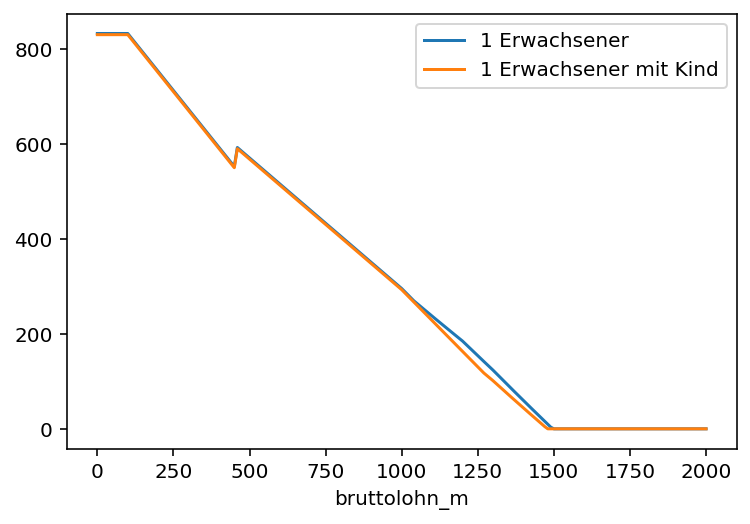

In [49]:
ergebnisse_singlehaushalt = ergebnisse.query("hhtyp == '1 Erwachsener' | hhtyp == '1 Erwachsener mit Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_singlehaushalt.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transfers', ax=ax, label=label);

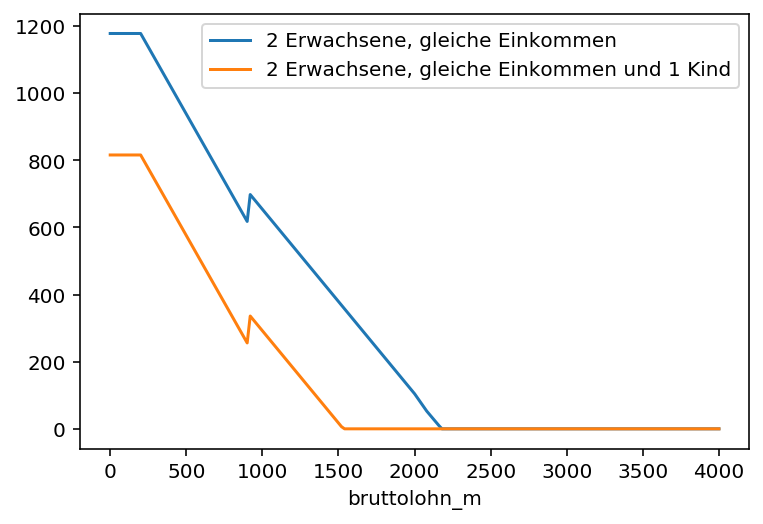

In [50]:
ergebnisse_2ek = ergebnisse.query("hhtyp == '2 Erwachsene, gleiche Einkommen' | hhtyp == '2 Erwachsene, gleiche Einkommen und 1 Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_2ek.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transfers', ax=ax, label=label)
plt.legend();

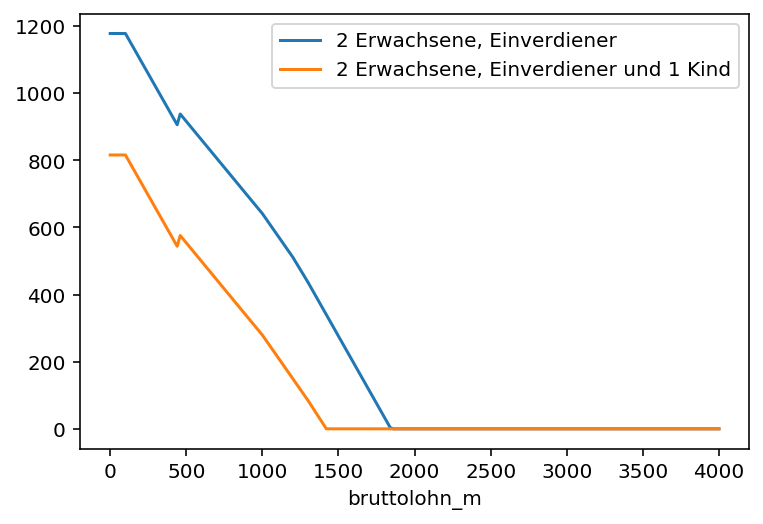

In [51]:
ergebnisse_2ek = ergebnisse.query("hhtyp == '2 Erwachsene, Einverdiener' | hhtyp == '2 Erwachsene, Einverdiener und 1 Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_2ek.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transfers', ax=ax, label=label)
plt.legend();

In [52]:
ergebnisse["transferentzugsrate"] = (ergebnisse["transfers"] - ergebnisse.groupby("hhtyp")["transfers"].shift(-1)) / 10
ergebnisse.head()

bruttolohn_m  eink_st_tu  soli_st_tu  rentenv_beitr_m  \
hhtyp         hh_id                                                          
1 Erwachsener 0               0.0         0.0         0.0              0.0   
              1              10.0         0.0         0.0              0.0   
              2              20.0         0.0         0.0              0.0   
              3              30.0         0.0         0.0              0.0   
              4              40.0         0.0         0.0              0.0   

                     arbeitsl_v_beitr_m  ges_krankenv_beitr_m  \
hhtyp         hh_id                                             
1 Erwachsener 0                     0.0                   0.0   
              1                     0.0                   0.0   
              2                     0.0                   0.0   
              3                     0.0                   0.0   
              4                     0.0                   0.0   

                     pflegev_beitr_m  arbeitsl_geld_m  arbeitsl_geld_2_m_hh  \
hhtyp         hh_id                                                           
1 Erwachsener 0                  0.0              0.0                 832.0   
              1                  0.0              0.0                 832.0   
              2                  0.0              0.0                 832.0   
              3                  0.0              0.0                 832.0   
              4                  0.0              0.0                 832.0   

                     transfers  transferentzugsrate  
hhtyp         hh_id                                  
1 Erwachsener 0          832.0                  0.0  
              1          832.0                  0.0  
              2          832.0                  0.0  
              3          832.0                  0.0  
              4          832.0                  0.0

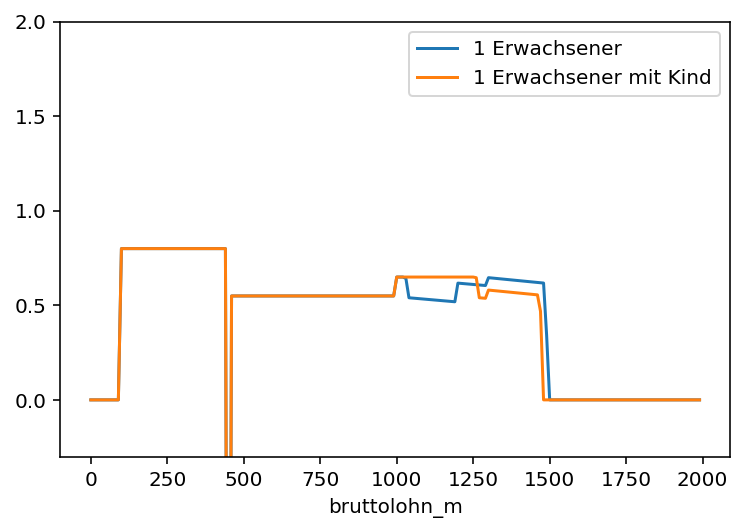

In [53]:
ergebnisse_singlehaushalt = ergebnisse.query("hhtyp == '1 Erwachsener' | hhtyp == '1 Erwachsener mit Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_singlehaushalt.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transferentzugsrate', ax=ax, label=label)
plt.ylim(-0.3, 2)
plt.legend();

(-0.3, 2)

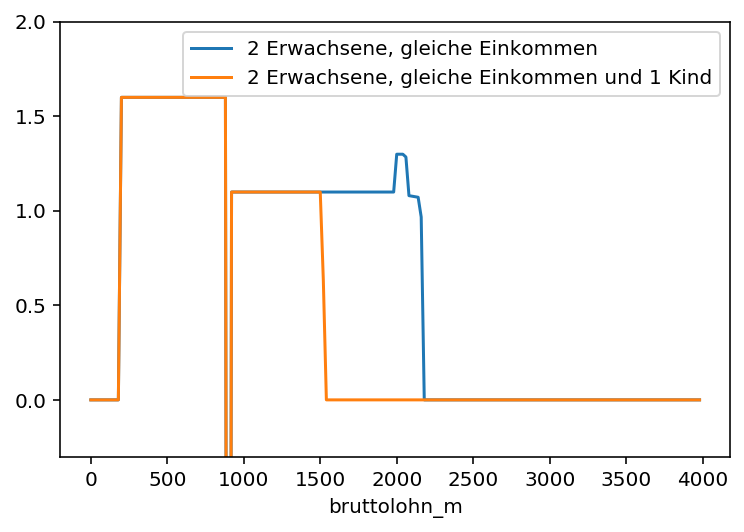

In [54]:
ergebnisse_2ek = ergebnisse.query("hhtyp == '2 Erwachsene, gleiche Einkommen' | hhtyp == '2 Erwachsene, gleiche Einkommen und 1 Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_2ek.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transferentzugsrate', ax=ax, label=label)
plt.legend();
plt.ylim(-0.3, 2)

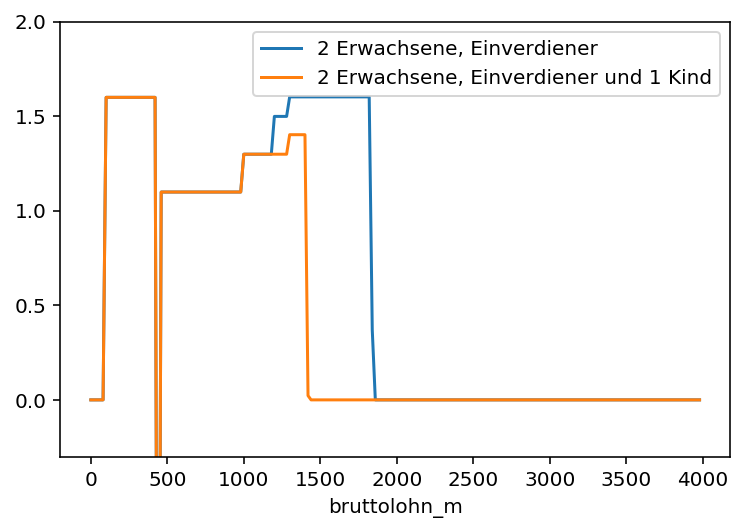

In [55]:
ergebnisse_2ek = ergebnisse.query("hhtyp == '2 Erwachsene, Einverdiener' | hhtyp == '2 Erwachsene, Einverdiener und 1 Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_2ek.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='transferentzugsrate', ax=ax, label=label)
    plt.ylim(-0.3, 2)
plt.legend();

## Aufgabe 1: Interpretation der Graphiken

Warum unterscheidet sich die drei Linien für die Transfers so stark? Bitte bedenken Sie die Definition von `bruttolohn_m` als durchschnittliches Haushaltseinkommen.

*Hier Platz für Ihre Antwort*

Bei welchen Beträgen und warum sehen wir Sprünge in den Linien für Transfers und für Transferentzugsraten?

*Hier Platz für Ihre Antwort*

## Aufgabe 2: Wiederholen Sie die Analyse ab "Transfers und Transferentzugsrate" für das verfügbare durchschnittliche Haushaltseinkommen und die gesamte Grenzbelastung aus Transferentzug und Steuern! 

In [56]:
ergebnisse["verfügbares einkommen"] = (
    ergebnisse['bruttolohn_m']
    + ergebnisse['transfers']
    - ergebnisse['eink_st_tu']
    - ergebnisse['soli_st_tu']
    - ergebnisse['rentenv_beitr_m']
    - ergebnisse['arbeitsl_v_beitr_m']
    - ergebnisse['ges_krankenv_beitr_m']
    - ergebnisse['pflegev_beitr_m']
)

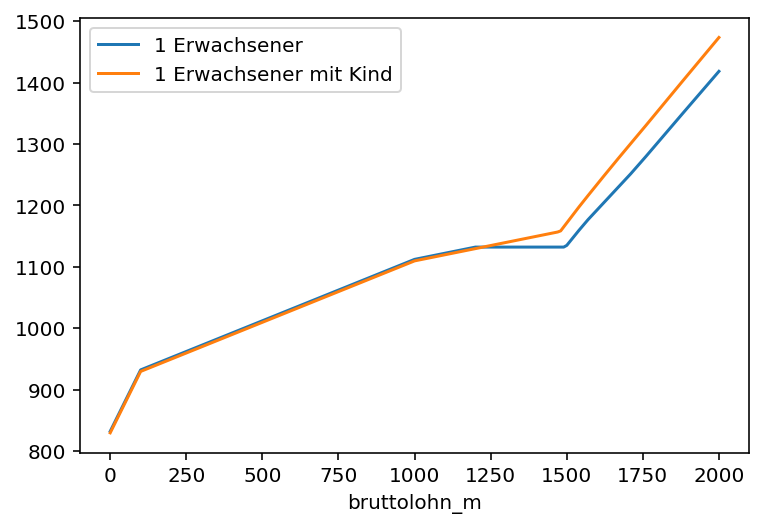

In [57]:
ergebnisse_singlehaushalt = ergebnisse.query("hhtyp == '1 Erwachsener' | hhtyp == '1 Erwachsener mit Kind'")
fig, ax = plt.subplots()
for label, df in ergebnisse_singlehaushalt.groupby("hhtyp"):
    df.plot(x='bruttolohn_m', y='verfügbares einkommen', ax=ax, label=label)
plt.legend();

In [52]:
ergebnisse["grenzbelastung gesamt"] = (ergebnisse["verfügbares einkommen"] - ergebnisse.groupby("hhtyp")["verfügbares einkommen"].shift(-1)) / 10 + 1

In [63]:
# Hier ihre plots

## Aufgabe 3: Was treibt die Unterschiede zwischen Haushalten mit und ohne Kinder? Verursachen diese Unterschiede unterschiedliche Arbeitsanreize?


*Hier Platz für Ihre Antwort*